In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches
from scarches.models import TRANVAE
from scarches.dataset import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.set_figure_params(dpi=100)

In [4]:
batch_key = 'study'
cell_type_key = 'cell_type'


tranvae_epochs = 500
leave_out_cell_types = ['Pancreas Alpha']
target_batches = ['Pancreas CelSeq2', 'Pancreas SS2']
n_labelled_samples_per_class = 50

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [5]:
# Save right dir path
dir_path = os.path.expanduser(f'~/Documents/tranvae/panc_ood_2/')
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
control_path = f'{dir_path}controlling/'
if not os.path.exists(control_path):
    os.makedirs(control_path)

In [6]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/pancreas_normalized.h5ad'))
adata = adata_all.raw.to_adata()

In [7]:
query = np.array([s in target_batches for s in adata.obs[batch_key]])
adata_ref_full = adata[~query].copy()
adata_ref = adata_ref_full[~adata_ref_full.obs[cell_type_key].isin(leave_out_cell_types)].copy()
adata_query = adata[query].copy()


In [8]:
adata_ref

AnnData object with n_obs × n_vars = 7584 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [9]:
un_labels_r = adata_ref.obs['cell_type'].unique().tolist()
un_labels_r

['Pancreas Endothelial',
 'Pancreas Acinar',
 'Pancreas Beta',
 'Pancreas Delta',
 'Pancreas Stellate',
 'Pancreas Ductal',
 'Pancreas Gamma']

In [10]:
adata_query

AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [11]:
un_labels_q = adata_query.obs['cell_type'].unique().tolist()
un_labels_q

['Pancreas Alpha',
 'Pancreas Delta',
 'Pancreas Beta',
 'Pancreas Ductal',
 'Pancreas Acinar',
 'Pancreas Gamma',
 'Pancreas Endothelial',
 'Pancreas Stellate']

In [12]:
labeled_ind = []
unlabeled_ind = []
for label in un_labels_r:
    mask = adata_ref.obs['cell_type'] == label
    mask = mask.tolist()
    idx = np.where(mask)[0]
    np.random.shuffle(idx)
    labeled_ind += idx[:n_labelled_samples_per_class].tolist()
    unlabeled_ind += idx[n_labelled_samples_per_class:].tolist()

print(len(labeled_ind))
print(len(unlabeled_ind))

350
7234


In [13]:
labeled_ind_q = []
unlabeled_ind_q = []
for label in un_labels_q:
    mask = adata_query.obs['cell_type'] == label
    mask = mask.tolist()
    idx = np.where(mask)[0]
    np.random.shuffle(idx)
    labeled_ind_q += idx[:n_labelled_samples_per_class].tolist()
    unlabeled_ind_q += idx[n_labelled_samples_per_class:].tolist()

print(len(labeled_ind_q))
print(len(unlabeled_ind_q))

400
4987


In [14]:
trvae = scarches.models.TRVAE(
    adata=adata_ref,
    condition_key=batch_key,
    hidden_layer_sizes=[128, 128],
    use_mmd=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [15]:
trvae.train(
    n_epochs=100,
    alpha_epoch_anneal=200,
)

 |████████████████████| 100.0%  - epoch_loss: 12281.39 - epoch_recon_loss: 12265.82 - epoch_kl_loss:   31.43 - val_loss: 3284.13 - val_recon_loss: 3273.06 - val_kl_loss:   22.3728
Saving best state of network...
Best State was in Epoch 99


In [16]:
tranvae = scarches.models.TRANVAE(
    adata=adata_ref,
    condition_key=batch_key,
    cell_type_key=cell_type_key,
    labeled_indices=labeled_ind,
    hidden_layer_sizes=[128, 128],
    use_mmd=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [17]:
torch.save(trvae.model.state_dict(), f'{dir_path}ref_state_dict')
tranvae.model.load_state_dict(torch.load(f'{dir_path}ref_state_dict'))

<All keys matched successfully>

In [18]:
tranvae.train(
    n_epochs=tranvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    tau=0,
)

 |███████-------------| 37.0%  - epoch_loss: 2351.36 - epoch_trvae_loss: 2340.37 - epoch_classifier_loss:   10.99 - epoch_unlabeled_loss:    0.87 - epoch_labeled_loss:    0.23 - val_loss: 1218.44 - val_trvae_loss: 1206.99 - val_classifier_loss:   11.45 - val_unlabeled_loss:    0.55 - val_labeled_loss:    0.591
ADJUSTED LR
 |████████------------| 41.8%  - epoch_loss: 2348.51 - epoch_trvae_loss: 2338.11 - epoch_classifier_loss:   10.40 - epoch_unlabeled_loss:    0.84 - epoch_labeled_loss:    0.20 - val_loss: 1216.24 - val_trvae_loss: 1205.32 - val_classifier_loss:   10.92 - val_unlabeled_loss:    0.53 - val_labeled_loss:    0.56
ADJUSTED LR
 |████████------------| 43.2%  - epoch_loss: 2335.71 - epoch_trvae_loss: 2325.23 - epoch_classifier_loss:   10.48 - epoch_unlabeled_loss:    0.82 - epoch_labeled_loss:    0.23 - val_loss: 1213.37 - val_trvae_loss: 1202.48 - val_classifier_loss:   10.89 - val_unlabeled_loss:    0.52 - val_labeled_loss:    0.57
Stopping early: no improvement of more tha

In [19]:
print("Acc: {}".format(np.mean(tranvae.classify() == adata_ref.obs[cell_type_key].tolist())))

Acc: 0.8416402953586498


In [20]:
landmarks_labeled = tranvae.model.landmarks_labeled.cpu().numpy()
landmarks_unlabeled = tranvae.model.landmarks_unlabeled.cpu().numpy()

X_ref = tranvae.get_latent()
X_ref = np.concatenate((X_ref,landmarks_labeled), axis=0)
X_ref = np.concatenate((X_ref,landmarks_unlabeled), axis=0)

pred_ref = tranvae.classify().tolist()
for key, value in tranvae.model.cell_type_encoder.items():
    pred_ref += [f'Landmark {key}']
pred_ref += landmarks_unlabeled.shape[0]*['Landmark unlabeled']

batch_ref = adata_ref.obs[batch_key].tolist() + landmarks_labeled.shape[0]*['Landmarks_labeled'] + landmarks_unlabeled.shape[0]*['Landmarks_unlabeled']
ct_ref = adata_ref.obs[cell_type_key].tolist()
for key, value in tranvae.model.cell_type_encoder.items():
    ct_ref += [f'Landmark {key}']
    
ct_ref += landmarks_unlabeled.shape[0]*['Landmark unlabeled']
ct_ref_orig = ct_ref.copy()

for i in unlabeled_ind:
    ct_ref[i] = 'Unknown'

In [21]:
latent_ref = sc.AnnData(X_ref)
latent_ref.obs['celltype'] = ct_ref
latent_ref.obs['celltype_orig'] = ct_ref_orig
latent_ref.obs['batch'] = batch_ref
latent_ref.obs['prediction'] = pred_ref
print(latent_ref.obs['celltype_orig'].unique().tolist())

['Pancreas Endothelial', 'Pancreas Acinar', 'Pancreas Beta', 'Pancreas Delta', 'Pancreas Stellate', 'Pancreas Ductal', 'Pancreas Gamma', 'Landmark Pancreas Endothelial', 'Landmark Pancreas Acinar', 'Landmark Pancreas Beta', 'Landmark Pancreas Delta', 'Landmark Pancreas Stellate', 'Landmark Pancreas Ductal', 'Landmark Pancreas Gamma', 'Landmark unlabeled']


In [22]:
sc.pp.neighbors(latent_ref, n_neighbors=8)
sc.tl.leiden(latent_ref)
sc.tl.umap(latent_ref)
latent_ref.write_h5ad(filename=f'{dir_path}reference_data.h5ad')

... storing 'celltype' as categorical
... storing 'celltype_orig' as categorical
... storing 'batch' as categorical
... storing 'prediction' as categorical


In [23]:
b_c = sc.pl.palettes.godsnot_102[10:16] + ['red']
batch_color = [b_c[5],b_c[6], b_c[2], b_c[3], b_c[0],b_c[4], b_c[1]]
ct_c = sc.pl.palettes.godsnot_102
ct_color = [ct_c[0], ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],ct_c[7],'black', ct_c[0], ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],ct_c[7],'grey']

<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

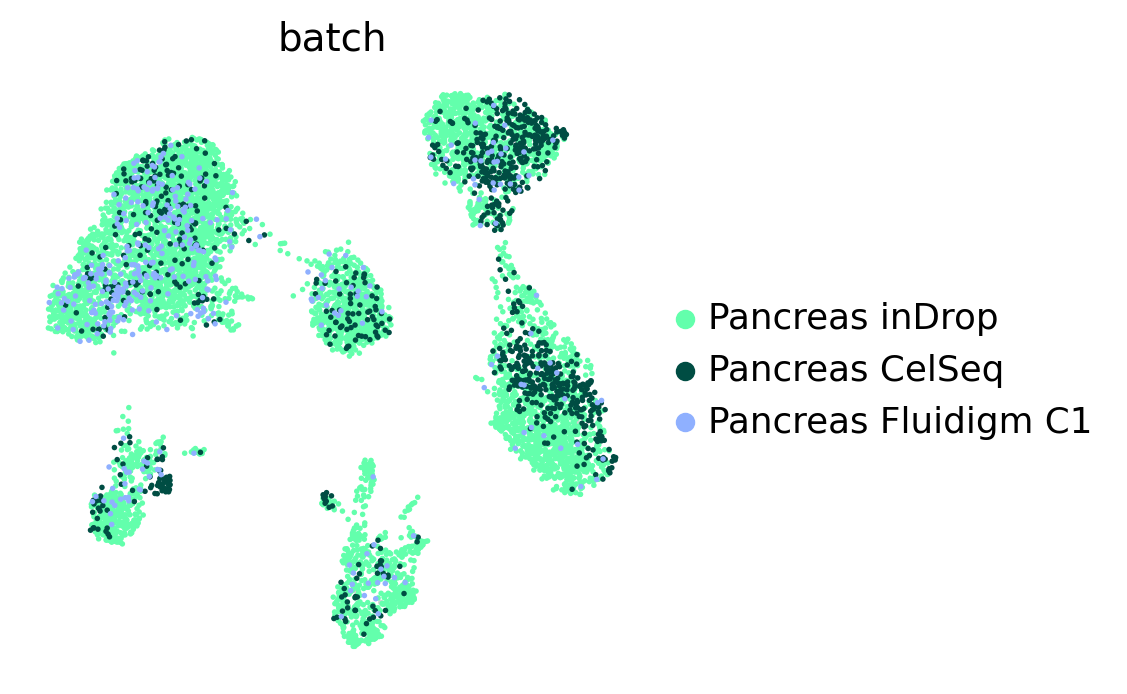

In [24]:
batches = adata_ref.obs[batch_key].unique().tolist()

sc.pl.umap(latent_ref,
           color=['batch'],
           frameon=False,
           groups=batches,
           wspace=0.6,
           show=False,
           palette=batch_color,
           )

<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

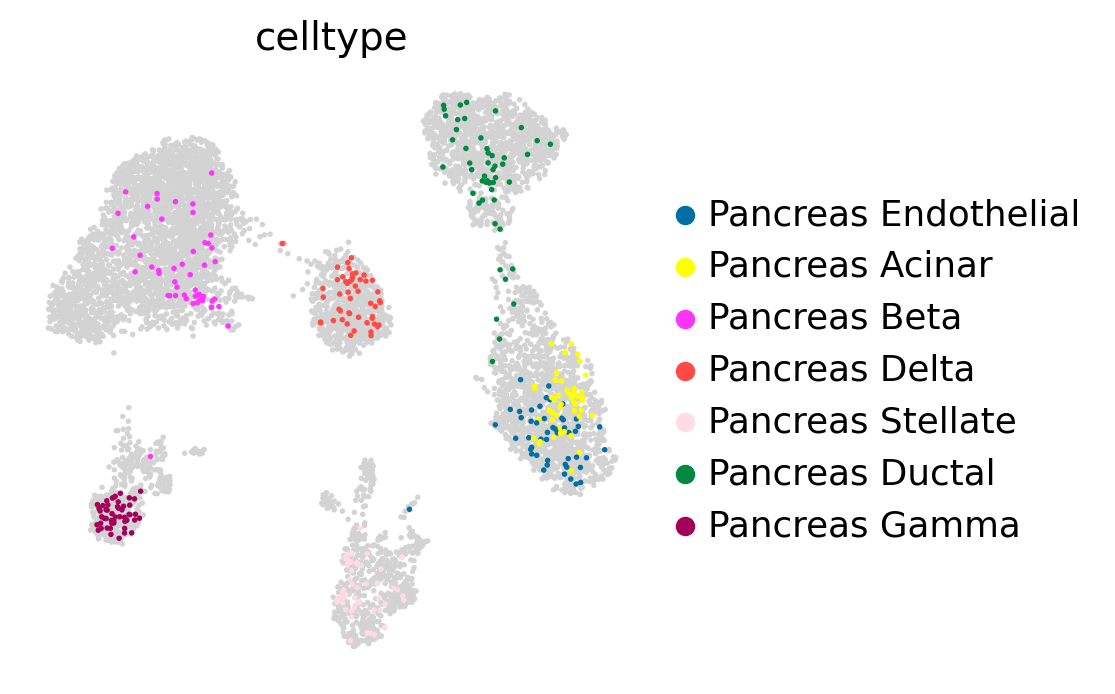

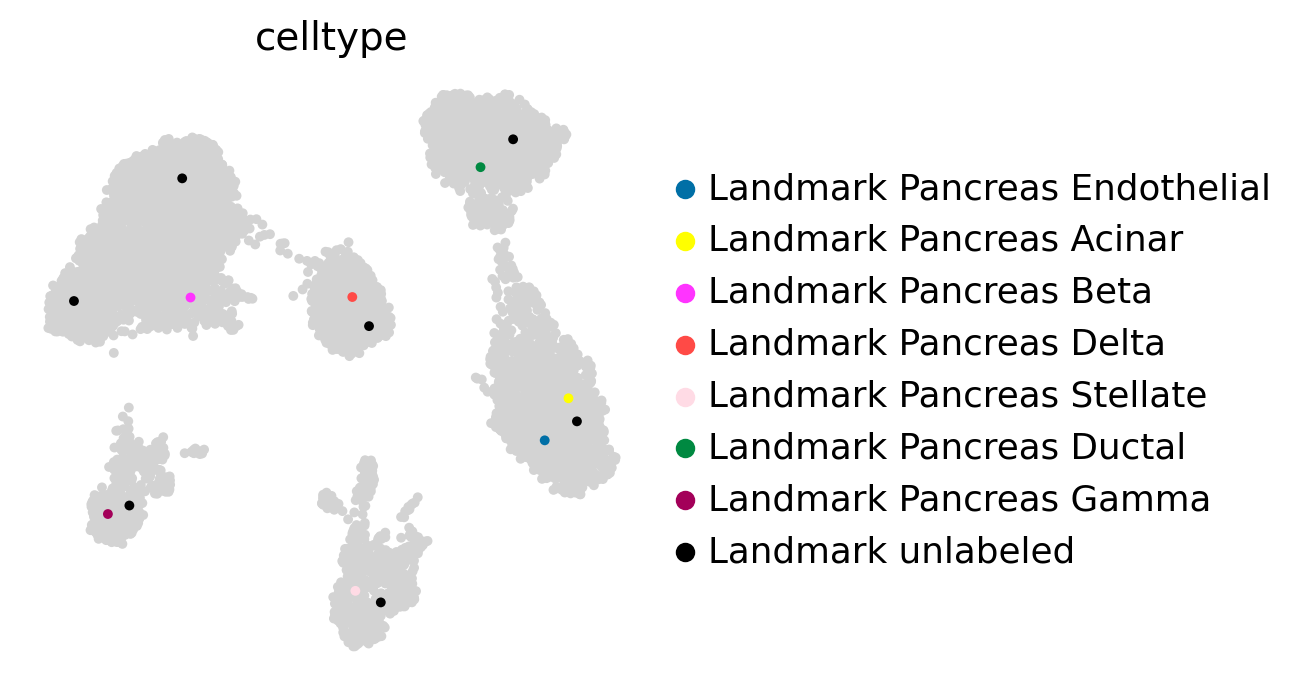

In [25]:
cts = adata_ref.obs[cell_type_key].unique().tolist()
lndmk_names = []
for key, value in tranvae.model.cell_type_encoder.items():
    lndmk_names += [f'Landmark {key}']
lndmk_names += ['Landmark unlabeled']


sc.pl.umap(latent_ref,
           color=['celltype'],
           frameon=False,
           groups=cts,
           wspace=0.6,
           show=False,
           palette=ct_color
          )
sc.pl.umap(latent_ref,
           color=['celltype'],
           frameon=False,
           groups=lndmk_names,
           wspace=0.6,
           show=False,
           palette=ct_color,
           size=50
          )

In [26]:
ref_path = f'{dir_path}reference_model/'
tranvae.save(ref_path, overwrite=True)

In [27]:
new_tranvae = scarches.models.TRANVAE.load_query_data(
    adata=adata_query,
    reference_model = ref_path,
    labeled_indices=labeled_ind_q,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [28]:
surgery_epochs=500
new_tranvae.train(
    n_epochs=surgery_epochs,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    tau=0,
    weight_decay=0
)

 |██████████████------| 71.4%  - epoch_loss: 2508.62 - epoch_trvae_loss: 2498.29 - epoch_classifier_loss:   10.34 - epoch_unlabeled_loss:    0.38 - epoch_labeled_loss:    0.65 - val_loss: 2558.15 - val_trvae_loss: 2544.71 - val_classifier_loss:   13.44 - val_unlabeled_loss:    0.38 - val_labeled_loss:    0.967685
ADJUSTED LR
 |███████████████-----| 75.0%  - epoch_loss: 2516.92 - epoch_trvae_loss: 2506.42 - epoch_classifier_loss:   10.50 - epoch_unlabeled_loss:    0.39 - epoch_labeled_loss:    0.66 - val_loss: 2616.21 - val_trvae_loss: 2602.60 - val_classifier_loss:   13.61 - val_unlabeled_loss:    0.39 - val_labeled_loss:    0.97
ADJUSTED LR
 |███████████████-----| 76.4%  - epoch_loss: 2499.53 - epoch_trvae_loss: 2488.41 - epoch_classifier_loss:   11.13 - epoch_unlabeled_loss:    0.39 - epoch_labeled_loss:    0.72 - val_loss: 2632.33 - val_trvae_loss: 2620.39 - val_classifier_loss:   11.94 - val_unlabeled_loss:    0.39 - val_labeled_loss:    0.81
Stopping early: no improvement of more 

In [29]:
landmarks_labeled_q = new_tranvae.model.landmarks_labeled.cpu().numpy()
landmarks_unlabeled_q = new_tranvae.model.landmarks_unlabeled.cpu().numpy()

X_q = new_tranvae.get_latent()
X_q = np.concatenate((X_q,landmarks_labeled_q), axis=0)
X_q = np.concatenate((X_q,landmarks_unlabeled_q), axis=0)
print(X_q.shape)

pred_q = new_tranvae.classify().tolist()
for key, value in new_tranvae.model.cell_type_encoder.items():
    pred_q += [f'Landmark {key}']
pred_q += landmarks_unlabeled_q.shape[0]*['Landmark unlabeled']

batch_q = adata_query.obs[batch_key].tolist() + landmarks_labeled_q.shape[0]*['Landmarks_labeled'] + landmarks_unlabeled_q.shape[0]*['Landmarks_unlabeled']
print(len(batch_q))
ct_q = adata_query.obs[cell_type_key].tolist()
for key, value in new_tranvae.model.cell_type_encoder.items():
    ct_q += [f'Landmark {key}']
    
ct_q += landmarks_unlabeled_q.shape[0]*['Landmark unlabeled']
print(len(ct_q))
ct_q_orig = ct_q.copy()

for i in unlabeled_ind_q:
    ct_q[i] = 'Unknown'

(5403, 10)
5403
5403


In [30]:
latent_q = sc.AnnData(X_q)
latent_q.obs['celltype'] = ct_q
latent_q.obs['celltype_orig'] = ct_q_orig
latent_q.obs['batch'] = batch_q
latent_q.obs['prediction'] = pred_q

In [31]:
sc.pp.neighbors(latent_q, n_neighbors=8)
sc.tl.leiden(latent_q)
sc.tl.umap(latent_q)
latent_q.write_h5ad(filename=f'{dir_path}query_data.h5ad')

... storing 'celltype' as categorical
... storing 'celltype_orig' as categorical
... storing 'batch' as categorical
... storing 'prediction' as categorical


In [32]:
b_c = sc.pl.palettes.godsnot_102[10:16] + ['red']
batch_color = [b_c[5],b_c[6], b_c[4], b_c[1]]

<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

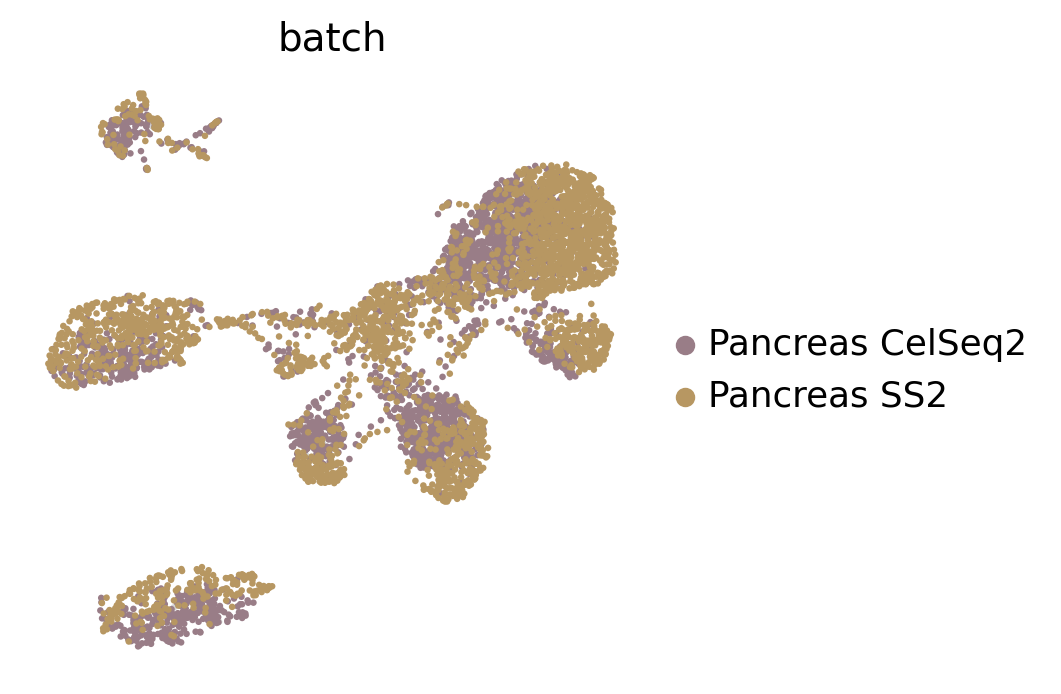

In [33]:
batches = adata_query.obs[batch_key].unique().tolist()

sc.pl.umap(latent_q,
           color=['batch'],
           frameon=False,
           groups=batches,
           wspace=0.6,
           show=False,
           palette=batch_color,
           )

In [34]:
ct_c = sc.pl.palettes.godsnot_102
ct_color = [ct_c[0], ct_c[7],ct_c[1],ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],'black', ct_c[0], ct_c[7],ct_c[1],ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],'black']

['Pancreas Alpha', 'Pancreas Delta', 'Pancreas Beta', 'Pancreas Ductal', 'Pancreas Acinar', 'Pancreas Gamma', 'Pancreas Endothelial']


<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

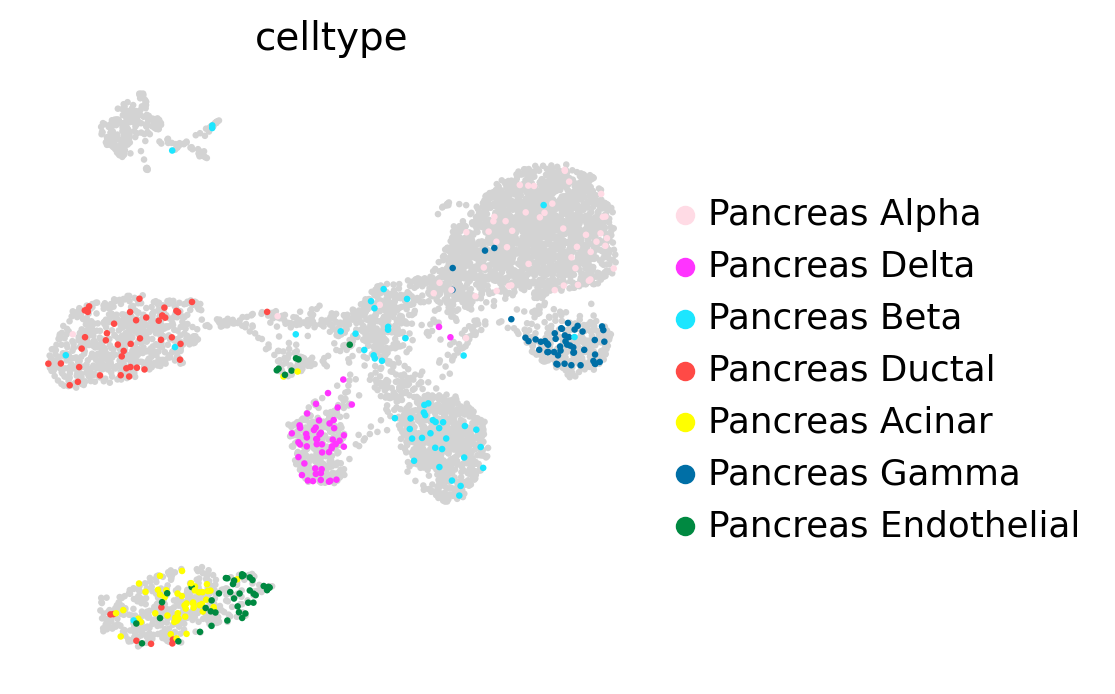

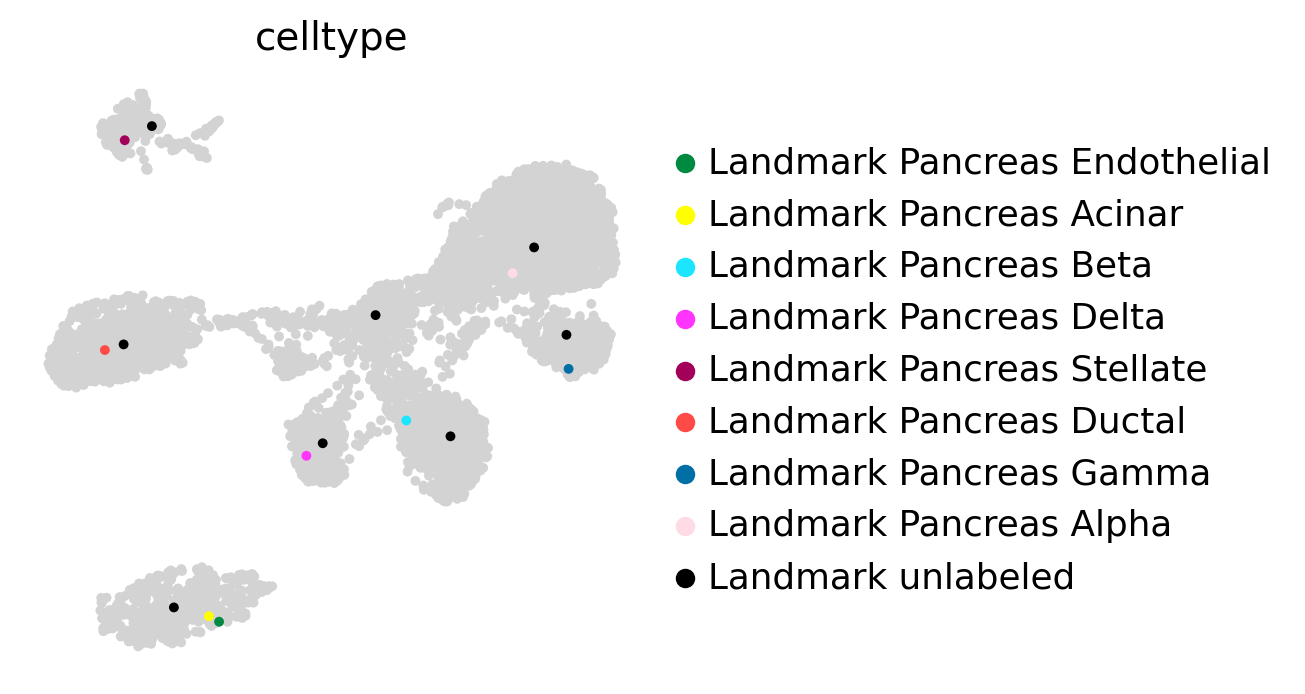

In [35]:
cts = adata_query.obs[cell_type_key].unique().tolist()
cts = cts[:7]
print(cts)
lndmk_names = []
for key, value in new_tranvae.model.cell_type_encoder.items():
    lndmk_names += [f'Landmark {key}']
lndmk_names += ['Landmark unlabeled']


sc.pl.umap(latent_q,
           color=['celltype'],
           frameon=False,
           groups=cts,
           wspace=0.6,
           show=False,
           palette=ct_color
          )
sc.pl.umap(latent_q,
           color=['celltype'],
           frameon=False,
           groups=lndmk_names,
           wspace=0.6,
           show=False,
           palette=ct_color,
           size=50
          )

In [36]:
print("Acc: {}".format(np.mean(new_tranvae.classify() == adata_query.obs[cell_type_key].tolist())))

Acc: 0.8462966400594023


In [37]:
adata_full = adata_ref.concatenate(adata_query)

In [38]:
X_f = new_tranvae.get_latent(adata_full.X, adata_full.obs[batch_key])
X_f = np.concatenate((X_f,landmarks_labeled_q), axis=0)
X_f = np.concatenate((X_f,landmarks_unlabeled_q), axis=0)
print(X_f.shape)

pred_f = new_tranvae.classify(adata_full.X, adata_full.obs[batch_key]).tolist()
for key, value in new_tranvae.model.cell_type_encoder.items():
    pred_f += [f'Landmark {key}']
pred_f += landmarks_unlabeled_q.shape[0]*['Landmark unlabeled']

batch_f = adata_full.obs[batch_key].tolist() + landmarks_labeled_q.shape[0]*['Landmarks_labeled'] + landmarks_unlabeled_q.shape[0]*['Landmarks_unlabeled']
print(len(batch_f))
ct_f = adata_full.obs[cell_type_key].tolist()
for key, value in new_tranvae.model.cell_type_encoder.items():
    ct_f += [f'Landmark {key}']
    
ct_f += landmarks_unlabeled_q.shape[0]*['Landmark unlabeled']
print(len(ct_f))
ct_f_orig = ct_f.copy()
unlabeled_ind_q_f = list(np.asarray(unlabeled_ind_q) + len(adata_ref))
unlabeled_ind_f = unlabeled_ind
unlabeled_ind_f += unlabeled_ind_q_f
for i in unlabeled_ind_f:
    ct_f[i] = 'Unknown'

(12987, 10)
12987
12987


In [39]:
latent_f = sc.AnnData(X_f)
latent_f.obs['celltype'] = ct_f
latent_f.obs['celltype_orig'] = ct_f_orig
latent_f.obs['batch'] = batch_f
latent_f.obs['prediction'] = pred_f

In [40]:
sc.pp.neighbors(latent_f, n_neighbors=8)
sc.tl.leiden(latent_f)
sc.tl.umap(latent_f)
latent_f.write_h5ad(filename=f'{dir_path}full_data.h5ad')

... storing 'celltype' as categorical
... storing 'celltype_orig' as categorical
... storing 'batch' as categorical
... storing 'prediction' as categorical


In [41]:
b_c = sc.pl.palettes.godsnot_102[10:16] + ['red']
b_c[2], b_c[3], b_c[0],b_c[4], b_c[1]
batch_color = [b_c[5],b_c[6], b_c[2], b_c[1], b_c[3],b_c[4], b_c[0]]

<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

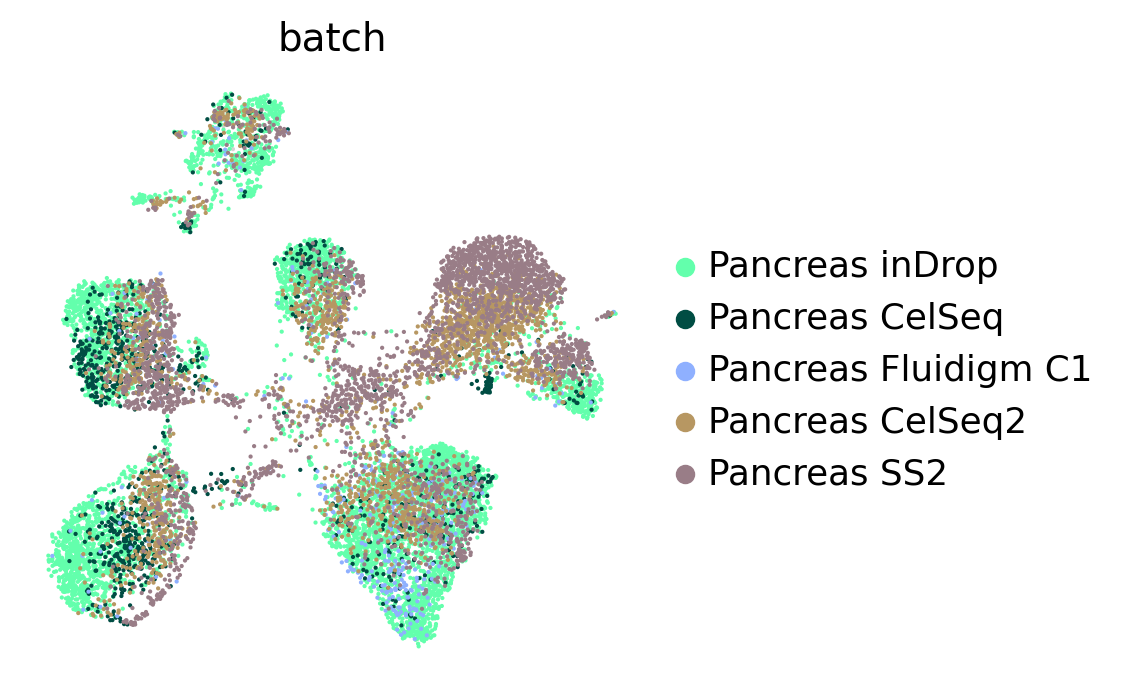

In [42]:
batches = adata_full.obs[batch_key].unique().tolist()

sc.pl.umap(latent_f,
           color=['batch'],
           frameon=False,
           groups=batches,
           wspace=0.6,
           show=False,
           palette=batch_color,
           )

In [43]:
ct_c = sc.pl.palettes.godsnot_102
ct_color = [ct_c[0], ct_c[7],ct_c[1],ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],'black', ct_c[0], ct_c[7],ct_c[1],ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],'black']

<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

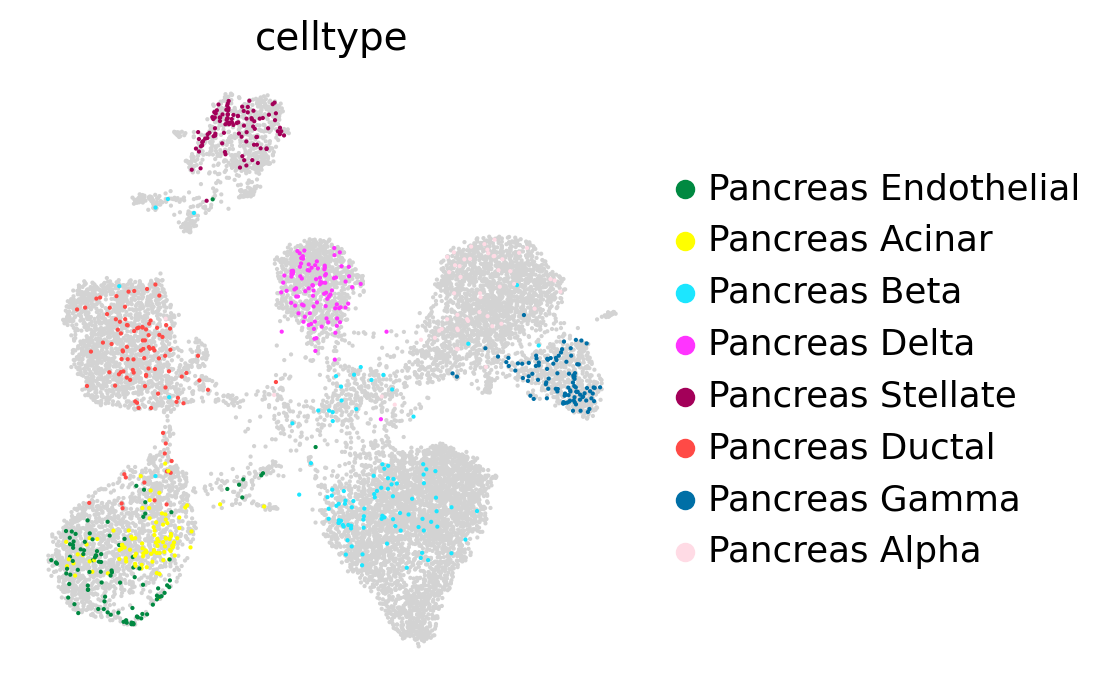

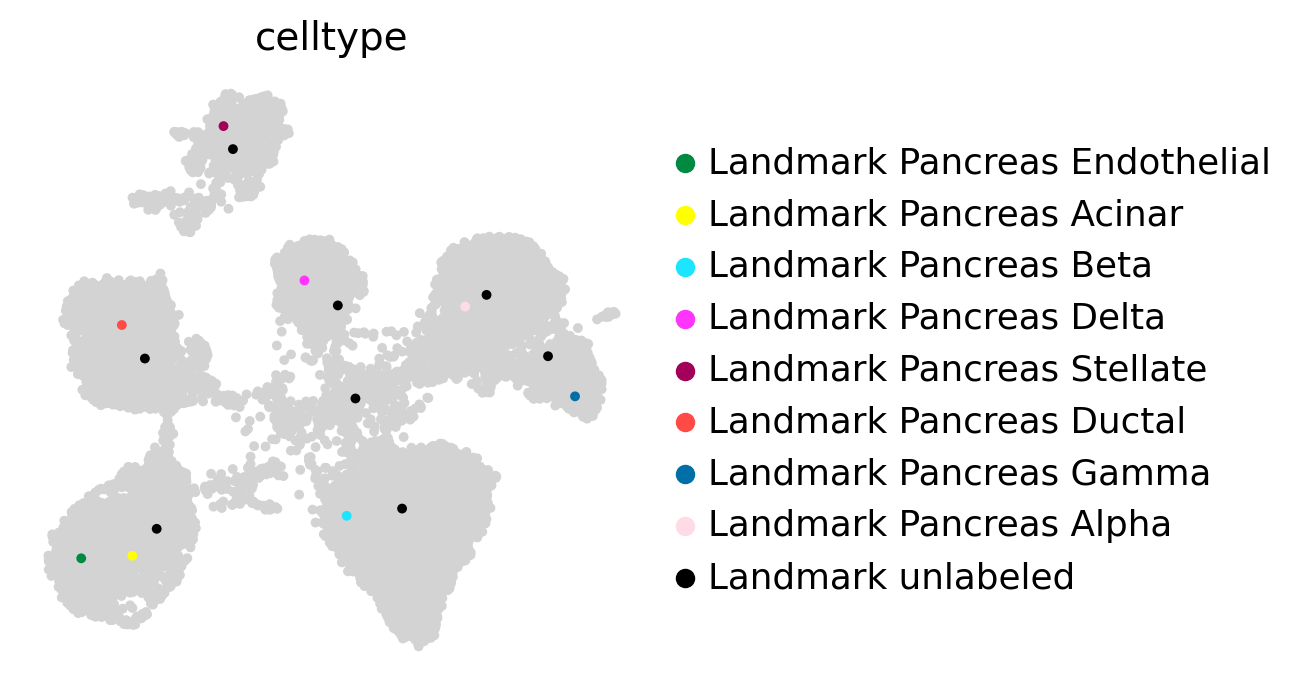

In [44]:
cts = adata_full.obs[cell_type_key].unique().tolist()
lndmk_names = []
for key, value in new_tranvae.model.cell_type_encoder.items():
    lndmk_names += [f'Landmark {key}']
lndmk_names += ['Landmark unlabeled']


sc.pl.umap(latent_f,
           color=['celltype'],
           frameon=False,
           groups=cts,
           wspace=0.6,
           show=False,
           palette=ct_color
          )
sc.pl.umap(latent_f,
           color=['celltype'],
           frameon=False,
           groups=lndmk_names,
           wspace=0.6,
           show=False,
           palette=ct_color,
           size=50
          )

In [45]:
print("Acc: {}".format(np.mean(new_tranvae.classify(adata_full.X, adata_full.obs[batch_key]) == adata_full.obs[cell_type_key].tolist())))

Acc: 0.8409528949194357
